In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import textblob
import gensim
import spacy
import os

import data
import plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Takes a 5 minutes the first time, but use `use_cached` afterward so you don't have to wait in the future.

In [5]:
train, train_vecs, test, test_vecs = data.get_data(use_cached=True)

train['utter_len'] = train['utter'].map(lambda x: len(x.split(' ')))

train['has_question_mark'] = train['utter'].map(lambda x: 1 if'?' in x.split(' ') else 0)
train = pd.concat([train, data.get_lags(train[['has_question_mark']], lag_range=[1])], axis=1)

Using Cached


In [6]:
LAG_MASK = ['act', 'emo', 'polarity', 'subjectivity']
train_lags = data.get_lags(train[LAG_MASK], lag_range=[1, 2])

Is first utterance?

### Classify Dialogue Acts

In [7]:
from collections import OrderedDict
from cycler import cycler

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_curve, confusion_matrix

from chatty.utils import dd_encodings

ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

X = np.concatenate((train_vecs,
                    train['first_utterance'].values.reshape(-1, 1),
                    train['subjectivity'].values.reshape(-1, 1),
                    train['utter_len'].values.reshape(-1, 1),
                    train['has_question_mark'].values.reshape(-1, 1)), axis=1)[ACT_MASK]
y = train['act'][ACT_MASK]

In [8]:
from sklearn.metrics import confusion_matrix

from sklearn.linear_model.logistic import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.svm import SVC

In [10]:
results = data.cv_stratified_shuffle(X, y,
                                     RandomForestClassifier(n_jobs=-1),
                                     splits=5)
plot.plot_prec_rec(results)

Training
Training
Training
Training
Training


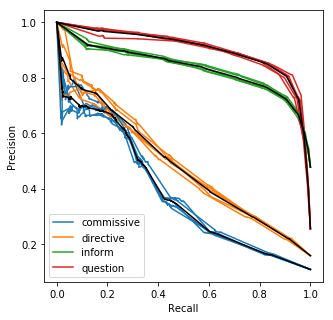

In [28]:
plot.plot_prec_rec(results)

In [112]:
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(results['classes'])

le.transform(results['y_true'][0])

array([0, 3, 0, ..., 3, 1, 0])

In [116]:
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))

Normalized confusion matrix
[[0.29977778 0.08977778 0.57022222 0.04022222]
 [0.03676583 0.39771167 0.38413425 0.18138825]
 [0.05080727 0.06276488 0.86543895 0.0209889 ]
 [0.00604344 0.06666667 0.06893296 0.85835694]]


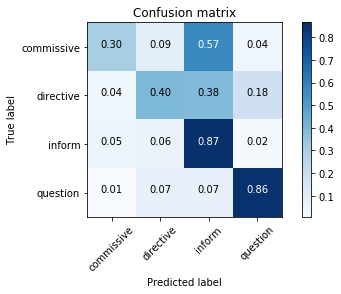

In [117]:
plot_confusion_matrix(cm, le.classes_, normalize=True)

In [113]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')